In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
np.set_printoptions(precision=4)

In [2]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = (t-t0)/(n-1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

## Problem Statement
\begin{align}
    J(u) &= \int_0^T \lambda + (1-\lambda)u^2 dt + M(x(T)^2 + v(T)^2) \\
    \dot{x} &= \frac{v}{\sqrt{1+f'(x)^2}}, x(0)=x_0 \\
    \dot{v} &= u - \frac{gf'(x)}{\sqrt{1+f'(x)^2}}, v(0)=v_0
\end{align}

In [4]:
# global variables
g = 9.81
min_u = -1
max_u = 1

#surface
x = sy.symbols('x') 
f = 0#-sy.cos(x/2)

fp = sy.diff(f)
norm = 1 / sy.sqrt(1+fp**2)
normp = sy.diff(norm)
fp_norm = fp* norm
fp_normp = sy.diff(fp_norm)

f_lam = sy.lambdify(x, f)
fp_lam = sy.lambdify(x, fp)
normp_lam = sy.lambdify(x, normp)
fp_normp_lam = sy.lambdify(x, fp_normp)

In [5]:
# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
    i : int
        
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the T cell concentration and the virus
        concentration at time t
    '''
    x = y[0]
    v = y[1]
    
    #calculate fp
    fp_x = fp_lam(x)

    #find vdot and pdot
    xdot = v / np.sqrt(1 + fp_x**2)
    vdot = u[i] - g*fp_x / np.sqrt(1 + fp_x**2)
    return np.array([xdot, vdot])

## Problem 2

In [6]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda_hat values at time t
    i : int
        index for global variables, u and state.
        
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the lambda_hats at time t.
    '''
    p1 = y[0]
    p2 = y[1]
    i = n-1-i
    x = state[i,0]
    v = state[i,1]
    
    #calculate fp
    fp_x = fp_lam(x)
    
    pd1 = -p1*v*normp_lam(x) + p2*g*fp_normp_lam(x)
    pd2 = -p1/np.sqrt(1+fp_x**2)
    return np.array([pd1, pd2])

## Problem 3

In [7]:
#parameters to tweak
lambda_ = 0
M = 100

#intial states
t_f = 10
x0 = -1
v0 = 0

n = 2000

# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([x0, v0])

costate = np.zeros((n,2))

u=np.zeros(n)-1

In [8]:
epsilon = 0.001
test = epsilon + 1
ones = np.ones(n)
max_iter = 1000
iters = 0
while(test > epsilon):
    oldu = u.copy();
    #solve the state equations with forward iteration
    state = RK4(state_equations, state0, 0, t_f, n)
    
    #solve the costate equations with backwards iteration
    costate0 = -2*M*state[-1]
    costate = RK4(lambda_hat, costate0, 0, t_f, n)[::-1]
    
    #solve for u1 and u2   
#     u1 = np.minimum(np.maximum(ones*min_u, costate[:,1] / (2*(1-lambda_))), ones*max_u)
    u1 = costate[:,1] / (2*(1-lambda_))
    
    #update control
    u = 0.5*(u1 + oldu)
    
    #test for convergence
    test = abs(oldu - u).sum()
    iters += 1
    if iters > max_iter:
        test = 0
    if iters % 100 == 0:
        print(iters)

/home/contagon6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/home/contagon6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


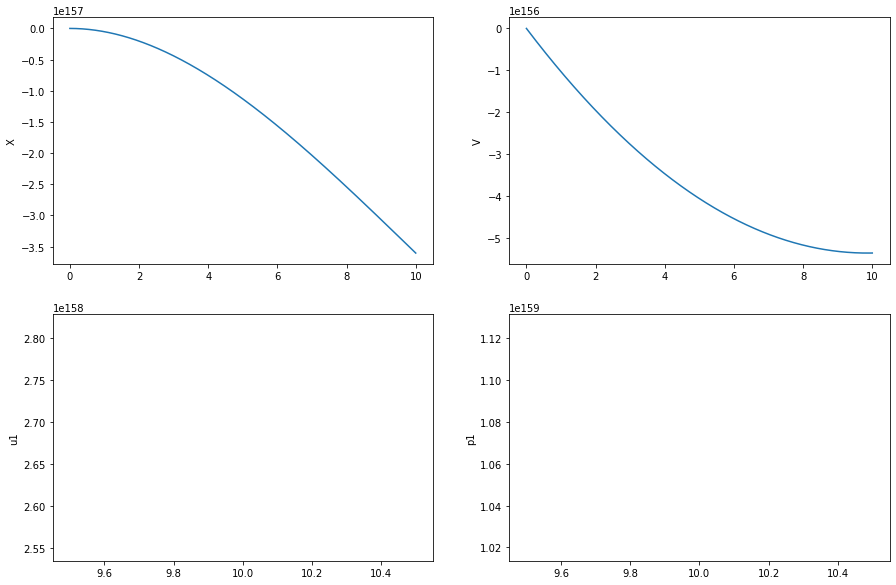

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
t = np.linspace(0, t_f, n)
ax[0, 0].plot(t, state[:,0])
ax[0, 0].set_ylabel('X')
ax[0, 1].plot(t, state[:,1])
ax[0, 1].set_ylabel('V')
ax[1, 0].plot(t, u)
ax[1, 0].set_ylabel('u1')
ax[1, 1].plot(t, costate[:,1])
ax[1, 1].set_ylabel('p1')
plt.show()